In this simulation we will model vibration noise in the phase shift $\Phi=\phi_{1}-2\phi_{2}+\phi_{3}$ gathered at the output (due to mirror vibration, Allan deviation etc.) of the three pulse interferometer. . For this modelling purpose we will use the sensitivity function formalism. The sensistivity function formalism allows us to determine the weight function that transforms noise in the laser pulse into interferometer phase noise. <br> 
The signal function is given by $g(t)=2\lim_{\delta\phi\to 0}\frac{\delta P}{\delta\phi}$. Here $P$ is the transition probability. For the problem at hand the transition probability is given by'[__1__],
\begin{align}
P(t)&=&\int dv P(z,v), P(z,v,t)=\frac{\Omega_{eff}(z)^{2}}{\Omega_{eff}(z)^{2}+\delta_{D}^{2}}\sin^{2}\left(\frac{t}{2}\sqrt{\Omega_{eff}(z)^{2}+\delta_{D}^{2}}\right), ~0<t<\tau\nonumber\\
    &=& \frac{1}{2}(1-cos(\phi_{1}-2\phi_{2}+\phi_{3})),  \tau<t<\tau+T
\end{align}
 where $\delta_{D}=k_{eff}v$ is the detuning, $k_{eff}$ is the two photon Rabi vector and $z$ is equal to t(TOF) multiplied by the mean velocity of the atoms.
Further let us note that there are two time scales in the problem (1)$\tau$ pulse duration time scale and (2)$T$ pulse separation time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
plt.rcParams['figure.figsize'] = [12,6]
kB=1.38*10**(-23)#Boltzmann constant in m^{2} kg s^{-2} K^{-1} 
#T=1.2*10**(-6)# in Kelvin
T=2.5*10**(-6)
#m=2.2*10**(-25) # in Kg
m=1.44*10**(-25) # in Kg 
#vel = np.linspace(0,0.04,1000)
#PmaxBoltz=(m/(2*np.pi*kB*T))**(1.5)*np.exp(-(m*vel*vel)/(2*kB*T))
#plt.plot(vel,PmaxBoltz)
mu, sigma = 0.0,(kB*T/m)**(0.5)# mean and std. dev.
velMag = np.random.normal(mu, sigma, 1000) 
print(velMag.max())
print(sigma)

0.051174616733493605
0.015478479684172255


__Obtaining a equivalent top hat intensity profile from a gaussian profile__

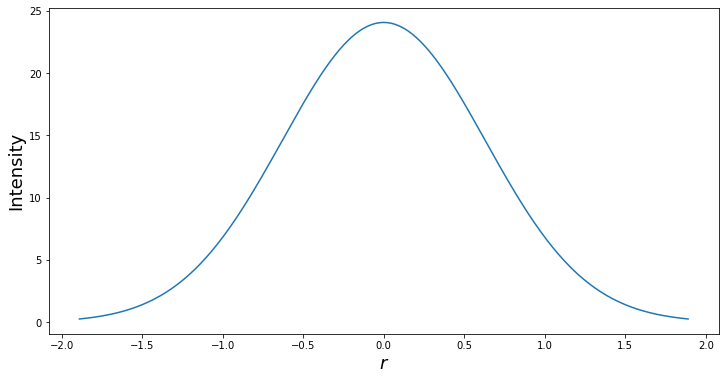

In [2]:
from scipy import integrate
#Power of  Gaussian
P=60 #in mW, Wu.et.al-> 60mW
#beam waist
#w1 =1.35#in cm, Wu.et.al-> 1.5
w1=1.26
I_P = 2*P/(np.pi*w1*w1)
#radial distance from beam centre
r=np.linspace(-1.5*w1,1.5*w1,301)
I = I_P*np.exp(-2*r**2/w1**2)
plt.xlabel(r"$r$",fontsize=18)
plt.ylabel(r"Intensity",fontsize=18)
plt.plot(r,I)

In [3]:
#saturation intensity
Isat= 1.669 # mW/cm^2, circular polarisation
#linewidth
Gamma = 6.0666e6 
#hyperfine splitting
#hfs = 3.0357324390e9
hfs = 6.83468261090e9 #hyperfine splitting
#Modulation index for the EOM
beta = 1.068
#computing effective Rabi frequency as a local distance z
A0 = np.sqrt(I/Isat)*Gamma*(mp.besselj(-1,beta)/np.sqrt(2))
A1 = np.sqrt(I/Isat)*Gamma*(mp.besselj(0,beta)/np.sqrt(2))
A2 = np.sqrt(I/Isat)*Gamma*(mp.besselj(1,beta)/np.sqrt(2))
A3 = np.sqrt(I/Isat)*Gamma*(mp.besselj(2,beta)/np.sqrt(2))

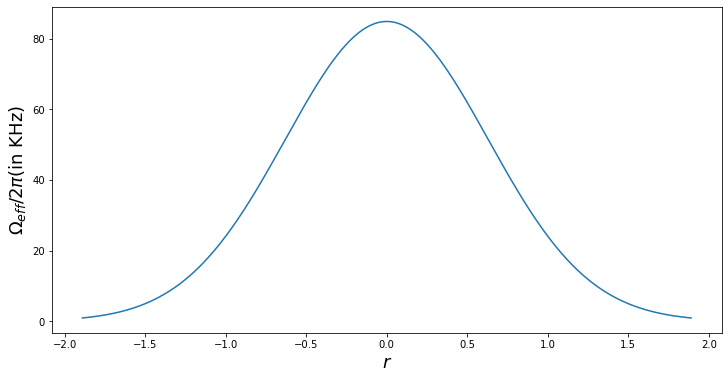

In [4]:
A=np.array([A0,A1,A2,A3])
#For Rb87
matElemF2=np.array([-np.sqrt(5/24), np.sqrt(1/8)])
matElemF3=np.array([np.sqrt(1/120), np.sqrt(1/8)])
nArr = np.array([-1,0,1])
#Relative frequency of F' excited states with respect to F'=5 state
relFreqF2 = np.array([423.597,266.65]) #in MHz
#Detuning for Rb87
Delta = -206.09218437
#Effective Rabi Frequency array for Top hat beam
OmegaEff = 0.0*r.copy()
for pos in r:
    for i in range(len(nArr)):
        for j in range(len(matElemF3)):
                #Detuning with respect to F=3 for the F' excited states
                DeltaF2n=nArr[i]*hfs+relFreqF2[j]*10**6+Delta*10**6
                OmegaEff[r==pos] = OmegaEff[r==pos]+(A[i][r==pos]*matElemF2[j]*A[i+1][r==pos]*matElemF3[j])*(1/(2*DeltaF2n))                                        
plt.plot(r,OmegaEff/(1000),linestyle='-')
plt.xlabel(r"$r$",fontsize=18)
plt.ylabel(r"$\Omega_{eff}/2\pi$(in KHz)",fontsize=18)
#Effective Rabi Frequency saturation value with top hat beam
OmgTopHat=np.max(OmegaEff)

### Logic to be followed for computing contrast for the Cesium atom based Raman three pulse AI

1>First construct the sensitivity function $g=\frac{\delta P}{\delta\phi}$ for the P given above. Then a partial integration over time leads to the integrated sensitivity function $f(t)$. This function is responsible in transferring the information of mechanical accerelation noise into the phase fluctuations.



In [5]:
#From  the above transition probabilities we can obtain the reciprocity region
1/OmgTopHat

1.1789608352657441e-05

In [6]:
#computing sensitivity function from Probability distribution
#tauPulseDuration=0.05*10**(-6) #11 mu secs tophat 3 mu secs gaussian
tauPulseDuration=7*10**(-6)
#interval
M=20#Duration over which the laser pulse interacts with the atomic cloud(pi/2 pulse)
t1=np.linspace(0,tauPulseDuration,M)
gt1=0.0*t1
#((OmegaEffMesh1*OmegaEffMesh1)/(OmgMesh1*OmgMesh1))*
for time in t1:
    gt1[t1==time]= -np.sin(2*np.pi*time*OmgTopHat)
#Pulse separation
#T=1.8*10**(-3) #0.5ms
T=20*10**(-3) #0.5ms
#No. of time steps
N=10000
#duration over which atomic clouds travel freely
t2=np.linspace(tauPulseDuration,T+tauPulseDuration,N)
gt2=-1+0.0*t2
#second duration over which atomic clouds interact with laser(pi pulse)
t3=np.linspace(T+tauPulseDuration,T+3*tauPulseDuration,2*M)
gt3=0.0*t3
for time in t3:
    gt3[t3==time]= -np.sin(2*np.pi*(time-T)*OmgTopHat)
#second duration over which atomic clouds travel freely
t4=np.linspace(T+3*tauPulseDuration,2*T+3*tauPulseDuration,N)
gt4=1+0.0*t4
#third duration over which atomic clouds interact with laser(pi/2 pulse)
t5=np.linspace(2*T+3*tauPulseDuration,2*T+4*tauPulseDuration,M)
gt5=0.0*t5
for time in t5:
    gt5[t5==time]= -np.sin(2*np.pi*(time-2*T)*OmgTopHat)

gt=np.concatenate((np.concatenate((np.concatenate((np.concatenate((gt1,gt2)),gt3)),gt4)),gt5))
t=np.concatenate((np.concatenate((np.concatenate((np.concatenate((t1,t2)),t3)),t4)),t5))

Text(0, 0.5, '$g(t)$')

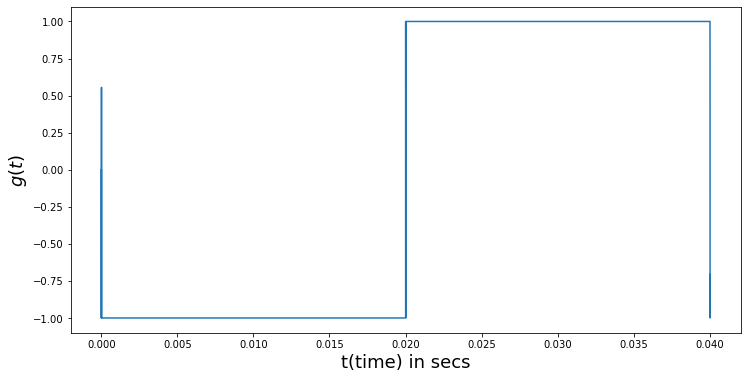

In [7]:
plt.plot(t,gt)
plt.xlabel("t(time) in secs",fontsize=18)
plt.ylabel(r"$g(t)$",fontsize=18)

Text(0, 0.5, '$f(t)$')

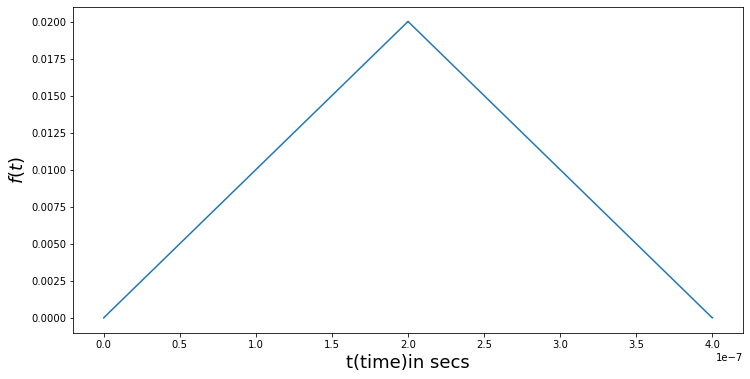

In [8]:
#Integrated sensitivity function
ft=-np.cumsum(gt)*(T/N)
plt.plot(t*10e-6,ft)
plt.xlabel("t(time)in secs",fontsize=18)
plt.ylabel(r"$f(t)$",fontsize=18)

In [9]:
T

0.02

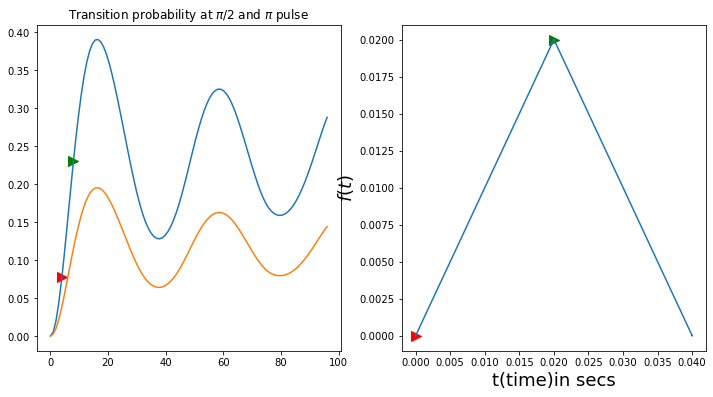

In [10]:
rMesh,velMagMesh = np.meshgrid(r,velMag)
z=r[70]
#tiltAngle
OmegaEffMesh,velMagMesh=np.meshgrid(2*np.pi*OmegaEff,velMag)
#momentum transfer from laser
k=(4*np.pi/780)*10**(9)
OmgMesh = np.sqrt(OmegaEffMesh*OmegaEffMesh+(k*velMagMesh)*(k*velMagMesh))
tauPulseDuration=4*10**(-6)
tauArr=np.sort(np.append(np.linspace(0.0,12*2*tauPulseDuration,100),[tauPulseDuration,2*tauPulseDuration]))
probTransArr=0.0*tauArr
for tau in tauArr:
    probTransTau = ((OmegaEffMesh*OmegaEffMesh)/(OmgMesh*OmgMesh))*np.sin((tau/2.)*OmgMesh)*np.sin((tau/2.)*OmgMesh)# Top-Hat Paper Equation 1
    probTransArr[tauArr==tau] =np.sum(probTransTau[rMesh==z][500:680])/180#/np.sum(probTransTau[500:1000])
figure,ax=plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [15,7]
#ax[0].plot(tauArr[tauArr>=tauPulseDuration]/10**(-6),probTransArr[tauArr>=tauPulseDuration])
#ax[0].plot(tauArr/10**(-6),probTransArr)
ax[0].plot(tauArr/10**(-6),probTransArr,tauArr/10**(-6),probTransArr/2)# value of other code will come here probTransG1Arr[tauArr==tau]



ax[0].scatter(tauPulseDuration/10**(-6),probTransArr[tauArr==tauPulseDuration],marker='>',s=100,color='red')
ax[0].scatter(2*tauPulseDuration/10**(-6),probTransArr[tauArr==2*tauPulseDuration][0],marker='>',s=100,color='green')
ax[0].set_title("Transition probability at %s and %s pulse"%(r'$\pi/2$',r'$\pi$'))
ax[1].plot(t,ft)
ax[1].set_xlabel("t(time)in secs",fontsize=18)
ax[1].set_ylabel(r"$f(t)$",fontsize=18)
ax[1].scatter(t[0],0,marker='>',s=100,color='red')
ax[1].scatter(t[10000],T,marker='>',s=100,color='green')

Transition Probabilities computed at $\tau=11\mu$(secs) and $2\tau=22\mu$(secs) for the $\pi/2$  and $\pi$ pulses respecitively. The Transition probability values at the initial raman pulse  $\pi/2$ and raman pulse $\pi$ allows us to determine the offset $P0=N1/(N1+N2)$ and the contrast $C$ leading to the modified transition probability formulae $P=P_{0}-\frac{C}{2}\cos(\Phi)$. Computation is as follows:

In [11]:
P0=(probTransArr[tauArr==tauPulseDuration]+probTransArr[tauArr==2*tauPulseDuration])/2.
C=(probTransArr[tauArr==2*tauPulseDuration]-probTransArr[tauArr==tauPulseDuration])
print("offset-",P0[0])
print("contrast-",C[0])

offset- 0.1541733742003762
contrast- 0.15260401670610324


In [12]:
probTransArr[tauArr==2*tauPulseDuration]

array([0.23047538])

This fitting parameters should get modulated via the random accerelations of the mechanical accerelometer which will be determined next 

In [13]:
#We will perform 3000 measurement cycles of 10**(-3)sec each for estimating fitting parameters of transition probability function
#Simulation at 0g
Tc=3*10**(-3)
PhiEstArr=np.zeros(3000)
ProbTransArr=np.zeros(3000)
for i in range(3000):
    #Measurement in a given experimental cycle
    #Modelling Mechanical Accerelometer(MA) noise over a period 2T(T being the time between light pulses) 
    meanAcc,sigmaAcc=0.7,8e-3
    #sinusoidally modulated accerelation noise
    np.random.seed()
    aMA=np.random.normal(meanAcc,sigmaAcc,len(t))
    PhiEstArr[i]=np.sum(k*ft*aMA)*(1/N)
    #Associated Transition Probability
    ProbTransArr[i]=P0[0]-(C[0]/2)*np.cos(PhiEstArr[i])


Text(0, 0.5, 'P(t)')

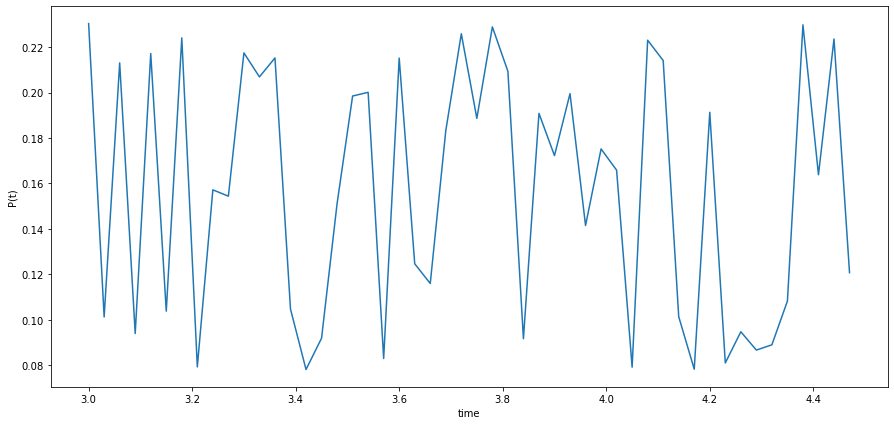

In [14]:
#plt.plot(Tc*np.arange(3000)*10,ProbTransArr)
plt.plot(Tc*np.arange(3000)[100:150]*10,ProbTransArr[100:150])

plt.xlabel('time')
plt.ylabel('P(t)')

### Next following Geiger DOI: 10.1038/ncomms1479 we determine the probability density function of the above Transition probability time series data P(t)

(0.0, 13.782949939078101)

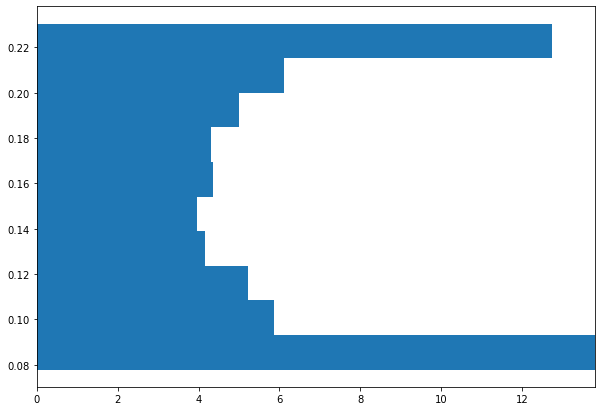

In [15]:
hist,bins=np.histogram(ProbTransArr,bins=10,range=(min(ProbTransArr),np.max(ProbTransArr)),density=True) 
x=(bins+np.roll(bins,-1))[:-1]/2.
plt.rcParams['figure.figsize'] = [10,7]
plt.hist(bins[:-1],bins,weights=hist,orientation='horizontal')
plt.xlim([0,hist.max()])

In [16]:
from scipy.stats import arcsine
from scipy.optimize import curve_fit
params=arcsine.fit(ProbTransArr)
loc=params[-2]
scale=params[-1]

C:\Users\Sajjad\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:496: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


In [17]:
pdf=arcsine.pdf(x,loc=loc,scale=scale)

In [18]:
Std=np.sum(np.power(hist-pdf,2.0))

In [19]:
Std

28.167411378163344

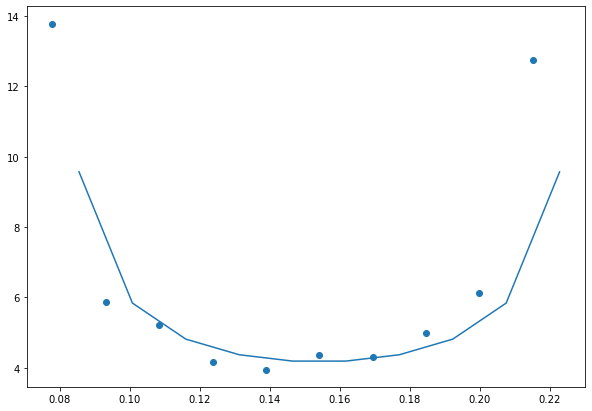

In [20]:
plt.plot(x,pdf)
plt.scatter(bins[:-1],hist)

In [21]:
pdf

array([9.57051669, 5.84153335, 4.81704848, 4.3731116 , 4.19269359,
       4.19268614, 4.37308622, 4.81699195, 5.84139222, 9.56971878])

In [22]:
x[pdf==pdf.max()]

array([0.08550157])

In [23]:
x

array([0.08550157, 0.10076197, 0.11602237, 0.13128277, 0.14654317,
       0.16180358, 0.17706398, 0.19232438, 0.20758478, 0.22284518])

In [24]:
P1=x[0]
P2=x[len(x)-1]

In [25]:
#Probability Amplitude
P0=(P2+P1)/2

In [26]:
#contrast
C=P2-P1

In [27]:
P0

0.1541733749233594

In [28]:
C

0.13734360266613704

(0.08550157359029087, 0.2228448366961699)

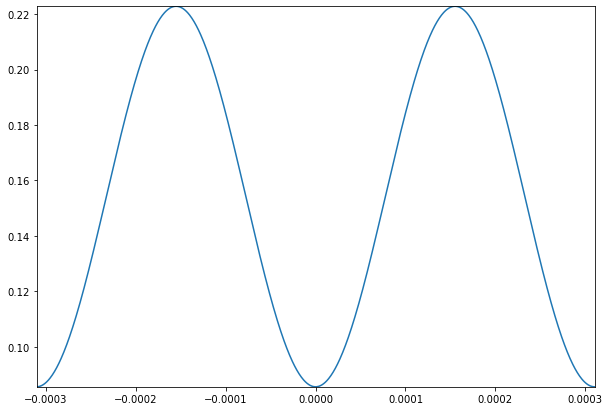

In [29]:
phi=np.linspace(-2*np.pi,2*np.pi,1000)
plt.plot((phi/(k*T**2))/np.pi,P0-(C/2)*np.cos(phi))
plt.xlim(np.min((phi/(k*T**2))/np.pi),np.max((phi/(k*T**2))/np.pi))
plt.ylim((P0-(C/2)*np.cos(phi)).min(),(P0-(C/2)*np.cos(phi)).max())